In [1]:
%matplotlib inline
import mne
import numpy as np
from scipy import signal
from leer_BCI42a import leer_bci42a_train_full
import os.path
import matplotlib.pyplot as plt

filename_train = 'A01T.gdf'
#Ch = np.array([0,2,3])#len(raw.ch_names)-4
Ch = np.arange(0,22)#np.arange(7,15)
vt = [0.5,2]#2*sfreq otf = 2 #5*sfreq
clases = [769,770]
i_muestras, i_clases, raw, Xraw, y, ni, m = leer_bci42a_train_full(filename_train,clases,Ch,vt)
Xraw.shape

Extracting EDF parameters from A01T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\andre\Anaconda3\lib\site-packages\mne\io\edf\edf.py:1086: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
G:\My Drive\UNAL\Clases\2019-1\ProcesoDigitalSeñales\Proyecto_BCI_MI_4_2a\leer_BCI42a.py:94: RuntimeWarning: Overlapping events detected. Use find_edf_events for the original events.
  raw = mne.io.read_raw_edf(path_filename,preload=False)
G:\My Drive\UNAL\Clases\2019-1\ProcesoDigitalSeñales\Proyecto_BCI_MI_4_2a\leer_BCI42a.py:94: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw = mne.io.read_raw_edf(path_filename,preload=False)
G:\My Drive\UNAL\Clases\2019-1\ProcesoDigitalSeñales\Proyecto_BCI_MI_4_2a\leer_BCI42a.py:94: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path_filename,preload=False)


(138, 22, 625)

In [2]:
sfreq=raw.info['sfreq']
vf = np.fft.rfftfreq(np.size(Xraw,2),1/sfreq)
F = abs(np.fft.rfft(Xraw,axis=2))
#ind = (vf>=3) & (vf<=30)
#F = F[:,:,ind]
#raw.ch_names
#Xraw.shape
#print(np.linalg.norm(F[10,:,:].flatten() - Xdata[10,:]))
#i_clases[m+1]

In [3]:
Sxx = abs(signal.stft(Xraw, sfreq, window='hann',nperseg=int(sfreq),noverlap=int(0.5*sfreq))[2])


In [4]:
import pywt 
w = pywt.Wavelet('db4')
cA, cD = pywt.dwt(Xraw, wavelet=w, mode='constant')


In [5]:
Xdata = Sxx.reshape(np.size(Sxx,0),-1)

#Xdata = F.reshape(np.size(F,0),-1)
#Xdata = np.append(Xdata,Sxx.reshape(np.size(Sxx,0),-1),axis=1)
#Xdata = np.append(Xdata,cA.reshape(np.size(cA,0),-1),axis=1)
#Xdata = np.append(Xdata,cD.reshape(np.size(cD,0),-1),axis=1)
Xdata.shape

(138, 16632)

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
scaler = StandardScaler()
Xdataz = scaler.fit_transform(Xdata)
pca = PCA(n_components=min(Xdataz.shape))
Z = pca.fit_transform(Xdataz)  

#tsne = TSNE(n_components=3, perplexity=10.0)
#Zt = tsne.fit_transform(Xdataz) 

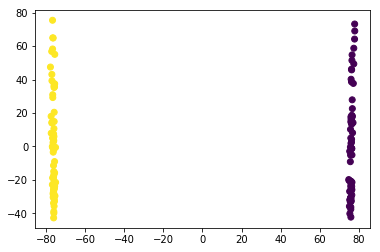

In [18]:
plt.scatter(Z[:,0],Z[:,1],c=y)


In [8]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#from mne.decoding import CSP
#csp = CSP(n_components=np.size(Xraw,1), reg=0.01, log=True, norm_trace=False)
#Xdata = csp.fit_transform(Xraw,y)
#plt.scatter(Xdata[:,0],Xdata[:,1],c=y)

steps = [('scaler', StandardScaler()), ('PCA', PCA()), ('SVM', SVC())]
#steps = [('scaler', StandardScaler()), ('SVM', SVC())]
pipeline = Pipeline(steps) # define the pipeline object.

X_train, X_test, y_train, y_test = train_test_split(Xdata,y,test_size=0.3, random_state=30, stratify=y)

In [9]:
from sklearn.model_selection import GridSearchCV
parameters = {'SVM__C':[0.001,0.1,10,100,10e3], 'SVM__gamma':[0.1,0.01,1,10]}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1,cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
grid_search.best_params_


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'SVM__C': 0.001, 'SVM__gamma': 0.01}

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
y_test_e = grid_search.predict(X_test)
print(confusion_matrix(y_test, y_test_e))
print("F1=%.4f" % f1_score(y_test, y_test_e)) 
print("Acc=%.4f" % accuracy_score(y_test, y_test_e)) 

[[21  0]
 [ 0 21]]
F1=1.0000
Acc=1.0000


In [11]:
from sklearn.model_selection import cross_val_score
best_model = grid_search.best_estimator_
scores = cross_val_score(best_model, Xdata, y, cv=10, scoring='f1')
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [14]:
from sklearn.externals import joblib #https://joblib.readthedocs.io/en/latest/
best_all = [best_model,"andres"]
joblib.dump(best_all, "my_best_model.pkl") # DIFF  https://docs.python.org/2/library/pickle.html
#...
my_model_loaded = joblib.load("my_best_model.pkl") # DIFF

In [16]:
my_model_loaded

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('PCA', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('SVM', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])